# Project 3: Skin Lesion Detection in Medical Treatment using Machine Learning
---

**Group 9: Aidan Stocks, Hugo Reinicke, Nicola Clark, Jonas-Mika Senghaas**

Submission: *19.04.2021* / Last Modified: *16.04.2021*

---

This notebook contains the step-by-step data science process performed on the *ISIC 2017* public test data and official training data on medical image recognition. The goal of this project was to extract and automatically analyse features from medical images of skin lesions in order to predict whether or not the person has ** using machine learning and image processing.

The initial data (containing the medical images, masked images and information on features and disease) was given for 150 medical images (equivalent to the public test data of the *ISIC 2017* challenge) by the project manager *Veronika *.
To develop more accurate models, we extended the initially given data by the official training data that could be obtained from the official [ISIC 2017 Website](https://challenge.isic-archive.com/data)

## Introduction
---
The amount of medical imaging - just as data in any other field - has increased tremendously within the last decade, making it more and more difficult to manually inspect medical images for diagnosis purposes.

Furthermore, people have proven to be hesitant of visiting doctors because of seemingly 'light' issues, which did not seem to be important enough to occupy a doctor's time. With skin diseases being especially effective in treatment if detected early, this is fatal. 
An easy-to-use app that implements automated detection of skin diseases from the sofa, would address this issue - ultimately saving lives.

## Running this Notebook
---
This notebook contains all code to reproduce the findings of the project as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of this project. In order to read in the data correctly, the global paths configured in the section `Constants` need to be correct. The following file structure - as prepared in the `submission.zip` - was followed throughout the project and is recommended to use (alternatively the paths in the section `Constants` can be adjusted):

```
*project tree structure*
```
*Note that the rest of the file structure as can be seen on the [GitHub](https://github.com/jonas-mika/fyp2021p03g09) page of the project generates automatically*

## Required Libraries and Further Imports
---
Throughout the project, we will use a range of both built-in and external Python Libraries. This notebook will only run if all libraries and modules are correctly installed on your local machines. 
To install missing packages use `pip install <package_name>` (PIP (Python Package Index) is the central package management system, read more [here](https://pypi.org/project/pip/)). 

In case you desire further information about the used packages, click the following links to find detailed documentations:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/stable/index.html)
- [PIL](https://pillow.readthedocs.io/en/stable/)
- [SciKit Learn](https://scikit-learn.org/stable/)
- [SciKit Image](https://scikit-image.org/)
- [Scipy](https://www.scipy.org/)

In [ ]:
%%capture
# uncomment lines with uninstalled packages

!pip install scikit-image
#!pip install scikit-learn
#!pip install pillow
#!pip install itertools

In [ ]:
# python standard libraries
import json                                            # data transfer to json format
import os                                              # automates saving of export files (figures, summaries, ...)
import random                                          # randomness in coloring of plots
import re                                              # used for checking dateformat in data cleaning
import math                                            # mathematical computations
import requests                                        # requesting from website 
import zipfile                                         # Used to extract zip files

# external libraries
import pandas as pd                                    # provides major datastructure pd.DataFrame() to store datasets
import numpy as np                                     # used for numerical calculations and fast array manipulations
import matplotlib.pyplot as plt                        # visualisation of data
import seaborn as sns
from PIL import Image                                  # fork from PIL (python image library), deals with images in python

# specific functions
import matplotlib.cm as cm
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # split data into train and test
from sklearn.preprocessing import StandardScaler # normalise features
from sklearn.neighbors import KNeighborsClassifier # k-nearest neighbour classifier
from sklearn.svm import SVC # support vector machine classifier
from sklearn.naive_bayes import GaussianNB # naive bayes
from sklearn.feature_selection import mutual_info_classif, SelectKBest # Univariate feature selection with mutual information for feature scoring

Since this project makes heavy use of functions to achieve maximal efficiency, all functions are stored externally in the package structure `project3'. The following imports are necessary for this notebook to run properly.

In [ ]:
#from project3.processing import ...
#from project3.save import ...
#from project3.features import ...
#from fyp2021p03g09_functions import *

**Remark**: All function used in this project are well documented in their *docstring*. To display the docstring and get an short summary of the function and the specifications of the input argument (including data tupe and small explanation) as well as their return value, type `?<function_name>` in Juptyer.

In [ ]:
# global parameters for running the notebooks
DOWNLOAD_EXTERNAL_IMAGES = False
PREPROCESS_IMAGES = False
COMPUTE_FEATURES = True

## Downloading Additional Data
---
*some description*

### Running on Local Machine

In [ ]:
if DOWNLOAD_EXTERNAL_IMAGES == True:
    # load in diagnosis, images and masks
    for i, url in enumerate(URL.values()):
        r = requests.get(url, allow_redirects=True) # request object
        if i == 1: open(PATH['data']['external'] + 'diagnosis.csv', 'wb').write(r.content)
        elif i == 2: open(PATH['data']['external'] + 'masks.zip', 'wb').write(r.content)
        elif i == 3: open(PATH['data']['external'] + 'images.zip', 'wb').write(r.content)

    # unzip images and masks
    for i, key in enumerate(URL.keys()[1:]):
        with zipfile.ZipFile(PATH['data']['external'] + key + '.zip','r') as zip_ref:
            zip_ref.extractall("../data/external")

    # delete zips

### Running from Deepnote 

In [ ]:
!ls /datasets/googledrive ####:(

## Constants
---
To enhance the readibilty, as well as to decrease the maintenance effort, it is useful for bigger projects to define contants that need to be accessed globally throughout the whole notebook in advance. 
The following cell contains all of those global constants. By convention, we write them in caps (https://www.python.org/dev/peps/pep-0008/#constants)

In [ ]:
URL = {}
URL['diagnosis'] = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
URL['masks'] = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip'
URL['images'] = 'https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip'

PATH = {}
PATH['data'] = {}
PATH['data']['raw'] = "../data/raw/"
PATH['data']['processed'] = "../data/processed/"
PATH['data']['external'] = "../data/external/"

PATH['images'] = 'images/'
PATH['masks'] = 'masks/'
PATH['filtered_images'] = 'filtered_images/'
PATH['dummy_images']= 'dummy_images/'

PATH['reports'] = "../reports/"

# filename lookup dictionary storing the most relevant filenames
FILENAME = {}

# store filename of datasets involved
FILENAME['diagnosis'] = 'diagnosis.csv'
FILENAME['features'] = 'features.csv' 

# store filenames of different files in the project for easy iteration
FILENAME['images'] = sorted([image[:-4] for image in os.listdir(PATH['data']['raw'] + PATH['images']) if not re.match('.*super.*', image)])
FILENAME['masks'] = sorted([mask[:-4] for mask in os.listdir(PATH['data']['raw'] + PATH['masks'])])
# add filenames for external
FILENAME['dummy_images'] = sorted([image[:-4] for image in os.listdir(PATH['data']['external'] + PATH['dummy_images'])])

# defining three dictionaries to store data. each dictionary will reference several pandas dataframes
DATA = {}

NAMES = {}
NAMES['datasets'] = ['diagnosis', 'features']
NAMES['images'] = ['images', 'masks']

**TASK 0**
# Image Preprocessing
---
In this section we preprocess our image to make it nicer to deal with them in the later part of the project.

1. Crop Images and Masks to be bound by lesion
2. Make Width and Length an even number to be able to crop evenly
3. Maybe save filtered image with color

In [ ]:
# helper function to make width and lengths even
def make_even(img):
    if img.size[0] % 2 != 0: #  making number of cols even
        img = np.array(img)
        mid = int(img.shape[1] / 2)
        img = np.delete(img, mid, axis=1)
        img = Image.fromarray(img)

    if img.size[1] % 2 != 0: # making number of rows even
        img = np.array(img)
        mid = int(img.shape[0] / 2)
        img = np.delete(img, mid, axis=0)
        img = Image.fromarray(img)
    
    return img

In [ ]:
# preprocessing (170 seconds to run)
if PREPROCESS_IMAGES == True:
    try: 
        os.makedirs(PATH['data']['processed'] + PATH['images'])
        os.makedirs(PATH['data']['processed'] + PATH['masks'])
        os.makedirs(PATH['data']['processed'] + PATH['filtered_images'])
    except: print('Directories already exist.')

    for i in range(len(FILENAME['images'])):
        # get image names
        img_name = FILENAME['images'][i] + '.jpg'
        mask_name = FILENAME['masks'][i] + '.png'

        # open temporarily
        img = Image.open(PATH['data']['raw'] + PATH['images'] + img_name)
        mask = Image.open(PATH['data']['raw'] + PATH['masks'] + mask_name)

        # crop to only store lesion
        cropped_img = img.crop(mask.getbbox())
        cropped_mask = mask.crop(mask.getbbox())

        # make width and length even (two cases)
        cropped_img = make_even(cropped_img)
        cropped_mask = make_even(cropped_mask)

        # create filtered with color
        dummy = Image.new("RGB", cropped_img.size, 0)
        filtered_img = Image.composite(cropped_img, dummy, cropped_mask)
        
        # save to '../data/processed' in correct subfolder
        cropped_img.save(PATH['data']['processed'] + PATH['images'] + img_name)
        cropped_mask.save(PATH['data']['processed'] + PATH['masks'] + mask_name)
        filtered_img.save(PATH['data']['processed'] + PATH['filtered_images'] + img_name)
        

        
    print('Preprocessing Done')

*TASK 0.5*
# Data Exploration

---


## Loading in Data

---

The task involves different sources of data, namely:

> **Images**: 150 Medical Images of Skin Lesions

> **Masks**: 150 Binary Masks corresponding to each Image that masks the region of the Skin Lesion

> **Diagnosis**: Dataset storing whether or not the lesion was either *melanoma* or *seborrheic_keratosis* through binary values

> **Features**: Dataset storing the area and perimeter of the skin lesion for each image

We conveniently load in the csv datasets into individual `Pandas DataFrames` using the built-in pandas method `pd.read_csv()`. We store those in our `DATA` dictionary in the corresponding keys.

All images and masks are stored as `Image` objects of the `PIL` (*Python Image Library*) for convenient handling of image processing functionality.

In [ ]:
# load in raw datasets 
DATA['diagnosis'] = pd.read_csv(PATH['data']['raw'] + FILENAME['diagnosis'])
DATA['features'] = pd.read_csv(PATH['data']['raw'] + FILENAME['features']) # not used in this project

In [ ]:
# load in raw images and masks
DATA['images'] = [Image.open(PATH['data']['processed'] + PATH['images'] + FILENAME['images'][i] + '.jpg') for i in range(len(FILENAME['images']))]
DATA['masks'] = [Image.open(PATH['data']['processed'] + PATH['masks'] + FILENAME['masks'][i] + '.png') for i in range(len(FILENAME['masks']))]

DATA['generator'] = ( (Image.open(PATH['data']['processed'] + PATH['images'] + FILENAME['images'][i] + '.jpg'),
                           Image.open(PATH['data']['processed'] + PATH['masks'] + FILENAME['masks'][i] + '.png')) 
                           for i in range(len(FILENAME['images'])) )

#DATA['generator'], DATA_RAW['generator_copy'] = itertools.tee(DATA_RAW['generator'])

## Inspection of Datasets

---

We can now have a look at our two datasets to get a first impression for what kind of data we are dealing with. We start by reporting the number of records and fields/ variables in each of the datasets by using the shape property of the `pd.DataFrame`. We then continue to have an actual look into the data. Similiar to the head command in terminal, we can use the method `head()` onto our DataFrames, which outputs an inline representation of the first five data records of the dataset.

**Shape**

In [ ]:
for dataset in NAMES['datasets']:
    print(f"{dataset.capitalize()}: {DATA[dataset].shape}")

Diagnosis: (150, 3)
Features: (150, 3)


**Diagnosis Dataset**

In [ ]:
DATA['diagnosis'].head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0001769,0.0,0.0
1,ISIC_0001852,0.0,0.0
2,ISIC_0001871,0.0,0.0
3,ISIC_0003462,0.0,0.0
4,ISIC_0003539,0.0,0.0


In [ ]:
%%capture
# add diagnosis to df

# extract cols
mel = DATA['diagnosis']['melanoma']
ker = DATA['diagnosis']['seborrheic_keratosis']

# mask all cases
mel_mask = (mel == 1) & (ker == 0)
ker_mask = (mel == 0) & (ker == 1)
neither_mask = (mel == 0) & (ker == 0)
both_mask = (mel == 1) & (ker == 1)

DATA['diagnosis']['diagnosis'] = 0
for i in range(DATA['diagnosis'].shape[0]):
    if mel_mask[i]: DATA['diagnosis']['diagnosis'].loc[i] = 2
    elif ker_mask[i]: DATA['diagnosis']['diagnosis'].loc[i] = 1
    else: DATA['diagnosis']['diagnosis'].loc[i] = 0

0: 78
1: 42
2: 30


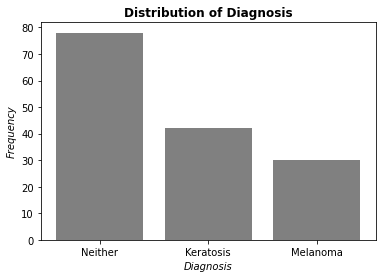

In [ ]:
# distribution of diagnosis

diagnosis, counts = np.unique(DATA['diagnosis']['diagnosis'], return_counts=True)

for x in range(len(diagnosis)):
    print(f"{diagnosis[x]}: {counts[x]}")

# plot
fig,ax = plt.subplots()
ax.bar(diagnosis, counts, color='gray')
# maybe add text with numeric count
ax.set_title('Distribution of Diagnosis', fontweight='bold'); ax.set_xlabel('Diagnosis', fontstyle='italic'); ax.set_ylabel('Frequency', fontstyle='italic');
ax.set_xticks(diagnosis); ax.set_xticklabels(['Neither', 'Keratosis', 'Melanoma']);

As we can see, the majority of observed skin lesions was healthy (78 / 150), one fifth of the skin lesions were diagnosed with melanoma and approximately one fourth was diagnosed with keratosis. 

The two diseases are - as expected - mutually exclusive, meaning that a single skin lesion cannot be diagnosed with multiple diseases.

**Features Dataset**

The features dataset so far only stores the area and perimeter for each given medical image. This dataset will be used to store all of our handcrafted features at a later point in the project.

In [ ]:
DATA['features'].head()

,id,area,perimeter
0,ISIC_0001769,216160.0,2013.0
1,ISIC_0001852,130493.0,1372.0
2,ISIC_0001871,205116.0,1720.0
3,ISIC_0003462,161705.0,1344.0
4,ISIC_0003539,317040.0,2063.0


## Inspection of Images
---
The main part of the project is to analyse medical images for a set of features. To do so, we can analyse both the original image and a binary mask provided in the raw data. In this section, we will look at examples of images and their corresponding mask to get a feel for the type of images we are dealing with and assess the quality of the masks.

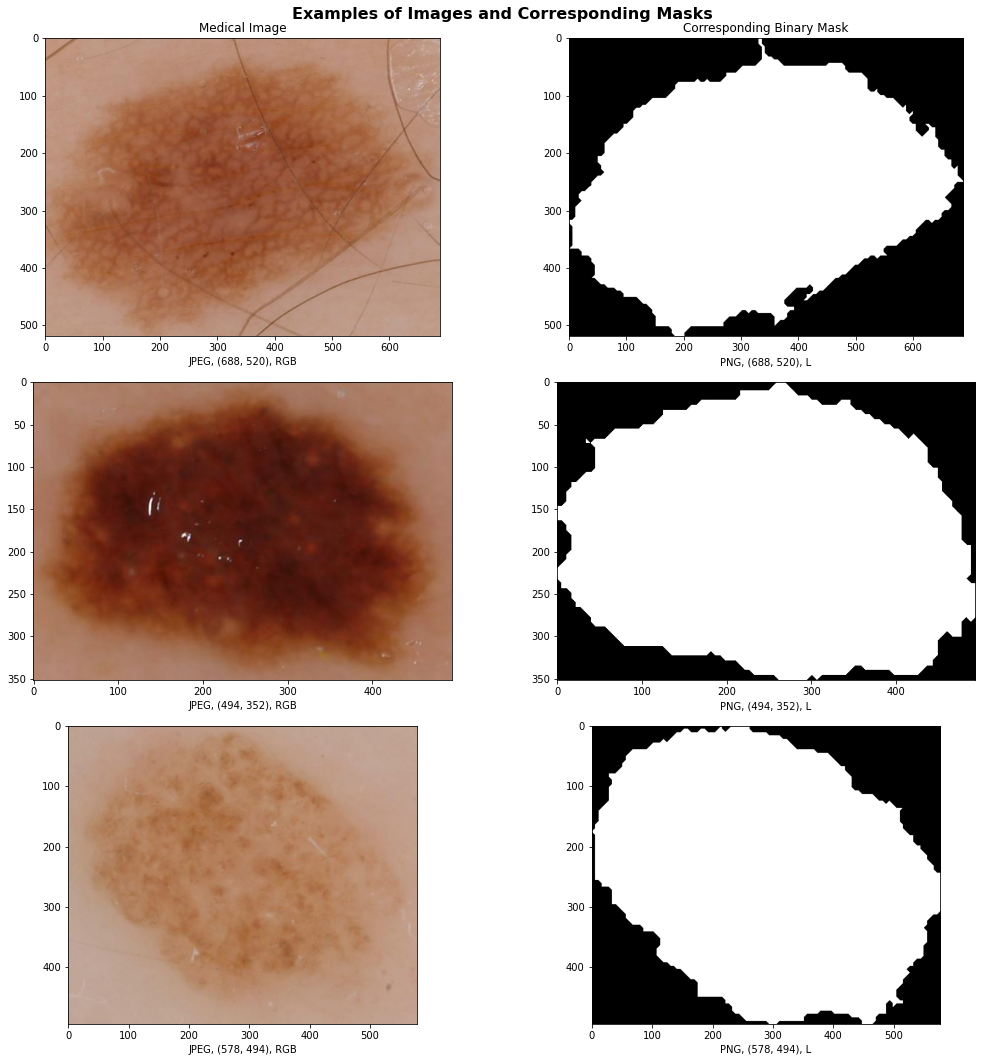

In [ ]:
# load test image using PIL
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
fig.suptitle('Examples of Images and Corresponding Masks', fontsize=16, fontweight='bold')

for i in range(3):
    ex_img = Image.open('../data/processed/images/' + FILENAME['images'][i] + '.jpg')
    ex_img_mask = Image.open('../data/processed/masks/' + FILENAME['masks'][i] + '.png')

    ax[i][0].imshow(ex_img)
    ax[i][0].set_xlabel(f"{ex_img.format}, {ex_img.size}, {ex_img.mode}");
    ax[i][1].imshow(ex_img_mask, cmap='gray')
    ax[i][1].set_xlabel(f"{ex_img_mask.format}, {ex_img_mask.size}, {ex_img_mask.mode}");

ax[0][0].set_title('Medical Image');
ax[0][1].set_title('Corresponding Binary Mask');

plt.tight_layout()

*TASK 1*
# Extracting Features 

---

We need to find quantitative measures of how to best classify the skin abnormalities. The following handcrafted features are assessed during this project:

> **Compactness**. A quantitative measure of the shape of the lesion. The smaller the value, the more compact the lesion is. A perfect circle has a compactness score of roughly *1.4*.

> **Average Luminance**. A quantitative measure of the averaged brightness of the lesion. The higher the value, the lighter the lesion, and vice versa. Values range from 0 (meaning 100% black) to 255 (meaning 100% white).

> **Luminance Variability**. A quantitative measure to determine the variation of luminance of the lesion. The higher the value, the more variation can be found on the lesion. 

> **Average Colour**. A quantitative measure of the averaged colour of the lesion. Values are in RGB format

> **Colour Variability**. A quantitative measure to determine the variation of color of the lesion. The higher the value, the more variation can be found on the lesion. output in the format of (rvariation,gvariation,bvariation),average variation

> **Asymmetry**. A quantitative measure to assess the symmetry of the lesion. Measured through relative number of non-overlapping pixels in different rotations. The higher the value, the less symmmetric the lesion is. A perfect circle, should score a 0 asymmetry score.

## Functions for Feature Extraction

In [ ]:
def measure_area_perimeter(mask):
    # Measure area: the sum of all white pixels in the mask image
    mask = np.where(np.array(mask)==255, 1, 0)
    
    # compute area as number of white pixels 
    area = np.sum(mask)

    # compute perimeter by eroding 1 pixel from mask and then compute the difference between original and eroded mask
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)
    
    return area, perimeter

In [ ]:
# compactness
def get_compactness(mask):
    area, perimeter = measure_area_perimeter(mask)

    # return compactness formula
    return ( ( perimeter ** 2) / (4 * np.pi * area ) )

In [ ]:
# average luminance
def get_average_luminance(filtered_image): # image needs to be filtered for lesion
    gray = np.array(filtered_image.convert('L')) # converting to gray scale 
    return round(np.mean(gray[gray > 0]))

In [ ]:
# luminance variability
def get_luminance_variability(filtered_image, measure='variance'):
    gray = np.array(filtered_image.convert('L')) # converting to gray scale 
    if measure == 'variance': return round(np.var(gray[gray > 0]))
    elif measure == 'standard_deviation': return round(np.std(gray[gray > 0]))
    else: print('Cannot compute this `measure`. Try `variance` or `standard_deviation`')

In [ ]:
# average color
def get_average_color(filtered_image): # image needs to be filtered for lesion
    r, g, b = filtered_image.split() # converting to separate channels  
    r= np.array(r) 
    g= np.array(g)
    b= np.array(b) 
    return [round(np.mean(r[r > 0])),round(np.mean(g[g > 0])),round(np.mean(b[b > 0]))]

In [ ]:
# color variability
def get_color_variability(filtered_image, measure='variance'): # image needs to be filteredd for lesion
    r, g, b = filtered_image.split() # converting to separate channels  
    r= np.array(r) 
    g= np.array(g)
    b= np.array(b) 
    if measure == 'variance': rgb=(np.var(r[r > 0]),np.var(g[g > 0]),np.var(b[b > 0]))
    elif measure == 'standard_deviation': rgb=(np.std(r[r > 0]),np.std(g[g > 0]),np.std(b[b > 0]))
    else: return 
    return np.mean(rgb)

In [ ]:
def get_asymmetry(mask):
    return round(np.mean([asymmetry(mask), asymmetry(mask.rotate(90, expand=True))]),2)

In [ ]:
# helper for asymmetry
def asymmetry(mask):
    # calculate basic properties of image
    width, length = mask.size  # requires even number of pixels in both dimensions
    size = width * length

    if width%2!=0:
        print("Uneven Number of Pixels. Can't calculate asymmetry.")

    # cut in half and fold
    left = mask.crop((0,0,(width/2), length)) 
    right = mask.crop((width/2,0,width,length))
    right = right.transpose(Image.FLIP_LEFT_RIGHT)

    # get binary array of unequal positions (the closer the sum to 0, the better the symmetry)
    diff = np.where(np.array(left) != np.array(right), 1, 0)

    return np.sum(diff) / size # percentage of asymmetric pixels

## Evaluating Feature Extraction
---

Here we test the quality of the functions on sample lesions and dummy images.

###############   Dummy 1   ###############
Area / Perimeter      : 440464px / 2116px
Compactness           : 0.8089301905223416
Asymmetry             : 0.0px
Average Luminance     : 142
Luminance Variance    : 1017
Average Colors (RGB)  : [252, 92, 110]
Color Variability     : 1060.0278147020997

###############   Dummy 2   ###############
Area / Perimeter      : 193253px / 1806px
Compactness           : 1.3430722730474487
Asymmetry             : 0.05px
Average Luminance     : 94
Luminance Variance    : 68
Average Colors (RGB)  : [94, 94, 94]
Color Variability     : 67.8755454789472



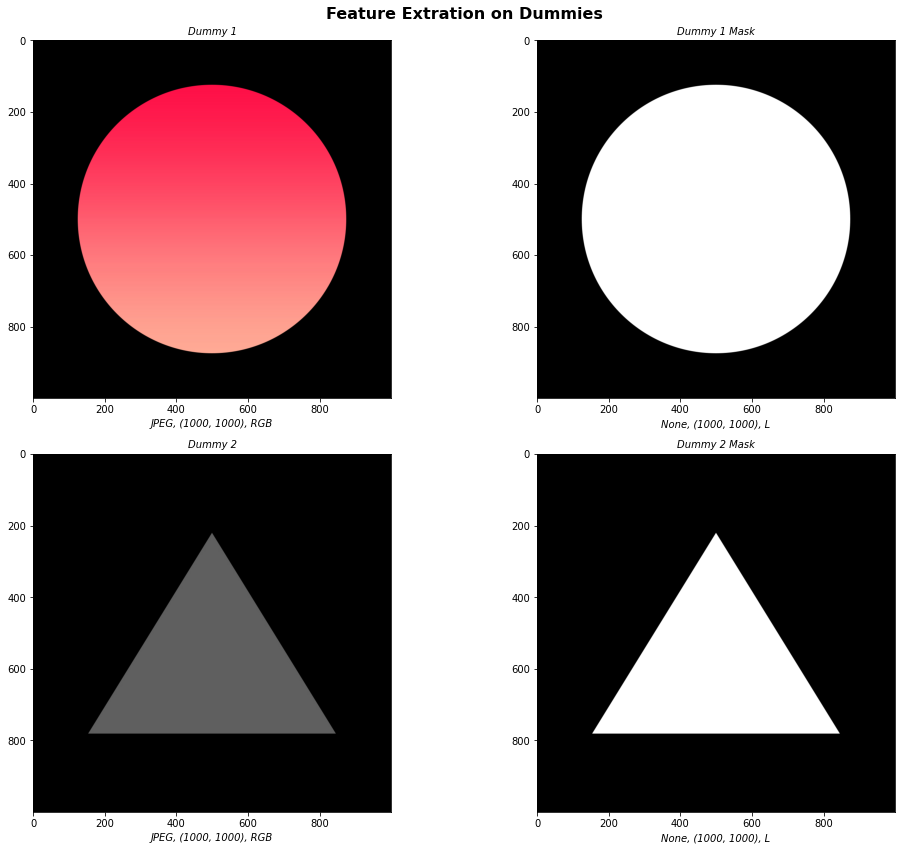

In [ ]:
dummies = ['dummy' + str(i+1) for i in range(2)]

# show dummy image and mask
fig, ax = plt.subplots(nrows=len(dummies), ncols=2, figsize=(16, 6 * len(dummies)))
fig.suptitle("Feature Extration on Dummies", fontsize=16, fontweight='bold')

for i, img_name in enumerate(dummies):
    # compute features
    img = Image.open('../data/external/dummy_images/' + img_name + '.jpg')
    img_mask = Image.open('../data/external/dummy_images/' + img_name + '_mask.png').convert('L')

    area, perimeter = measure_area_perimeter(img_mask)
    compactness = get_compactness(img_mask)
    asymmetry_score = get_asymmetry(img_mask)
    average_luminance = get_average_luminance(img)
    luminance_variance = get_luminance_variability(img)
    average_colors = get_average_color(img)
    color_variance = get_color_variability(img)

    # print out computed features
    print('#'*15 + f"   Dummy {i+1}   " + '#'*15)
    print(f"Area / Perimeter      : {area}px / {perimeter}px")
    print(f"Compactness           : {compactness}")
    print(f"Asymmetry             : {asymmetry_score}px")
    print(f"Average Luminance     : {average_luminance}")
    print(f"Luminance Variance    : {luminance_variance}")
    print(f"Average Colors (RGB)  : {average_colors}")
    print(f"Color Variability     : {color_variance}\n")

    ax[i][0].imshow(img);
    ax[i][1].imshow(img_mask, cmap='gray');
    ax[i][0].set_title(f'Dummy {i+1}', fontsize=10, fontstyle='italic')
    ax[i][1].set_title(f'Dummy {i+1} Mask', fontsize=10, fontstyle='italic')
    ax[i][0].set_xlabel(f'{img.format}, {img.size}, {img.mode}', fontstyle='italic');
    ax[i][1].set_xlabel(f'{img_mask.format}, {img_mask.size}, {img_mask.mode}', fontstyle='italic');
    plt.tight_layout()

## Compute Features
---

We have developed our functions to extract abstracted features from the medical images of the lesions and have proven them to work on dummy images, where we were able to validate assumed scores in each feature. We can therefore now compute the features for each image and append it to our main dataframe to store the data, that is later used to train our model. 

We first read in the measured features into a dictionary `feature_dict`, which we later concatenate horizontally with `features.csv` dataset. 

In [ ]:
features = ['compactness', 'average_luminance', 'luminance_variability', 'average_red', 'average_green', 'average_blue', 'color_variability', 'asymmetry']

feature_functions = {
    'compactness': get_compactness,
    'average_luminance': get_average_luminance,
    'luminance_variability': get_luminance_variability,
    'average_red': get_average_color,
    'average_green': get_average_color,
    'average_blue': get_average_color,
    'color_variability': get_color_variability,
    'asymmetry': get_asymmetry
}

In [ ]:
# compute all features (execution time: 60s)
if COMPUTE_FEATURES == True:
    feature_dict = {feature: [] for feature in features}

    for i in range(len(FILENAME['images'])):
        name = FILENAME['images'][i]
        img_name = FILENAME['images'][i] + '.jpg'
        mask_name = FILENAME['masks'][i] + '.png'

        # open temporarily
        filtered_img = Image.open(PATH['data']['processed'] + PATH['filtered_images'] + img_name)
        mask = Image.open(PATH['data']['processed'] + PATH['masks'] + mask_name)

        # measure features and append to feature_dict
        for feature in features:
            if feature in ['compactness', 'asymmetry']:
                feature_dict[feature].append(feature_functions[feature](mask))
            elif feature in ['average_luminance', 'luminance_variability', 'color_variability']:
                feature_dict[feature].append(feature_functions[feature](filtered_img))
            elif feature == 'average_red':
                feature_dict[feature].append(feature_functions[feature](filtered_img)[0])
            elif feature == 'average_green':
                feature_dict[feature].append(feature_functions[feature](filtered_img)[1])
            elif feature == 'average_blue':
                feature_dict[feature].append(feature_functions[feature](filtered_img)[2])

### Build Main DataFrame
---
*add small description*

In [ ]:
# append extracted features and diagnosis to features.csv
if DATA['features'].shape[1] <= 3:
    DATA['features'] = pd.concat([DATA['features'], pd.DataFrame(feature_dict)], axis=1) # concatenating handcrafted features
    DATA['features'] = pd.concat([DATA['features'], DATA['diagnosis'][['melanoma', 'seborrheic_keratosis', 'diagnosis']]], axis=1) # concatenating diagnosis

In [ ]:
DATA['features']

,id,area,perimeter,compactness,average_luminance,luminance_variability,average_red,average_green,average_blue,color_variability,asymmetry,melanoma,seborrheic_keratosis,diagnosis
0,ISIC_0001769,216160.0,2013.0,1.460703,108,977,155,96,66,780.760582,0.10,0.0,0.0,0
1,ISIC_0001852,130493.0,1372.0,0.983582,66,1164,111,53,32,1065.616653,0.06,0.0,0.0,0
2,ISIC_0001871,205116.0,1720.0,0.999238,138,1094,175,131,100,825.166031,0.13,0.0,0.0,0
3,ISIC_0003462,161705.0,1344.0,0.743362,123,1207,160,114,86,1157.012146,0.03,0.0,0.0,0
4,ISIC_0003539,317040.0,2063.0,1.058382,110,1337,160,97,62,1194.831694,0.21,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,ISIC_0015443,9732988.0,13775.0,1.180344,101,452,139,89,64,507.443671,0.05,0.0,0.0,0
146,ISIC_0015445,12049938.0,19517.0,2.387259,108,1946,154,91,82,1921.062199,0.29,0.0,0.0,0
147,ISIC_0015483,8856478.0,13813.0,1.445050,114,1339,142,105,92,1307.218390,0.04,0.0,0.0,0
148,ISIC_0015496,8951522.0,13742.0,1.490771,117,3638,172,98,78,3661.626976,0.10,0.0,0.0,0


### Normalise Features
---
When training our ML model, it is important that each feature equally contributes into the process of classification. Since features are on very different scales (*ie. 0-255 for Luminance/ Color or #Pixels for Asymmetry*), we normalise them using sklearn's `StandardScaler()` to normalise all numeric columns in the DataFrame `features.csv` and save the normalised DataFrame into `DATA['scaled_features']`.

In [ ]:
scaler = StandardScaler().fit(DATA['features'].loc[:, DATA['features'].columns != 'id'])
DATA['scaled_features'] = scaler.transform(DATA['features'].loc[:, DATA['features'].columns != 'id'])
DATA['scaled_features'] = pd.DataFrame(DATA["scaled_features"], columns=list(DATA['features'])[1:]) # convert back to pd.DataFrame
DATA['scaled_features']

### Saving DataFrame
---
Save both `feature` dataframes into `csv` format into `../data/processed`.

In [ ]:
# save features and scaled features
DATA['features'].to_csv(PATH['data']['processed'] + 'features.csv')
DATA['scaled_features'].to_csv(PATH['data']['processed'] + 'scaled_features.csv')

*TASK 1.5*
# Evaluate Features for Classification
---

In this section, we are plotting the handcrafted features in order to see, whether any correaltions appear. Since we are trying to classify a binary label, namely whether a lesion is diseased with *melanoma* or not, we plot the distribution of each feature in the two classes *melanoma* and *no melanoma* to get a visual intuition of how good the specific feature might be able to distinguish between our target label. 
The more distinct the two distributions are, the better the feature will be at prediciting the tartget value.

### Visual Exploration

In [ ]:
fig, ax = plt.subplots(nrows=len(features) + 2, figsize=(8, 6 * len(features) + 2))

for i, feature in enumerate(features + ['area', 'perimeter']):
    sns.violinplot(x='melanoma', 
                   y=feature, 
                   data=DATA['features'],  
                   ax=ax[i]).set_title(f"Distribution of {feature.title().replace('_', ' ')} in Different Classes");

In [ ]:
sns.pairplot(DATA['features'], hue='melanoma', height=2, diag_kind="hist"); 

*TASK 2*
# Predict Diagnosis

---

We have 'handcrafted' a number of features and now aim to find the model that is the most robust to predict our target variable - whether the lesion is our is not diseased with melanoma. In the process of doing so, a number of questions arise that we will step-by-step tackle in order to build the 'best' model. 



> **Selecting Features**: Which combination of features is likely do perform best?

> **Normalisation**: How do we make sure that each feature contributes equally to the model's prediction?

> **Which model does best in predicting our variable?**

> **Which hyperparameters should we use to create the best model?**

> **How do we evaluate the model? Which metrics do we use to assess whether or not our model does good?**

1. decide on _features_ and _target_ # features at random,but should decide for k best
#use feature selector or do randomly
2. normalise features 
3. _split into test, train and do cross validation (split into 5 sets)_
4. _evaluate_
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [ ]:
!pip install imblearn

In [ ]:
from imblearn.under_sampling import RandomUnderSampler # balancing data
from imblearn.over_sampling import RandomOverSampler # balancing data

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedShuffleSplit #for cross-validation
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Define Initial Features and Target Variable
---
First, we need to define from which set of features our model should choose the ones that are likely to perform best on a specified target variable. 
In our case, each measured feature is potentially interesting for the model, and we want to predict the binary label, whether or not the classifier is diseased with *melanoma* or not.

By, convention, we call the feature matrix `X` and the target column `y`.

In [ ]:
X = DATA['features'][features]
y = DATA['features'][['melanoma']]

### Normalisation
---
Our measured handcrafted features all perform on different scales, ie. the *average luminance* can only obtain values between 0 and 255, whereas the *asymmetry* is the number of non-matching pixels in two-folds.

Since we want each of our features to equally contribute to the prediction of the model, we need to normalise them. We do this through the formula of the standard score $\frac{x-\mu}{\sigma}$ ([Wikipedia](https://en.wikipedia.org/wiki/Standard_score)).

We can easily use `sklearn`'s `StandardScaler`, which does the job for us.

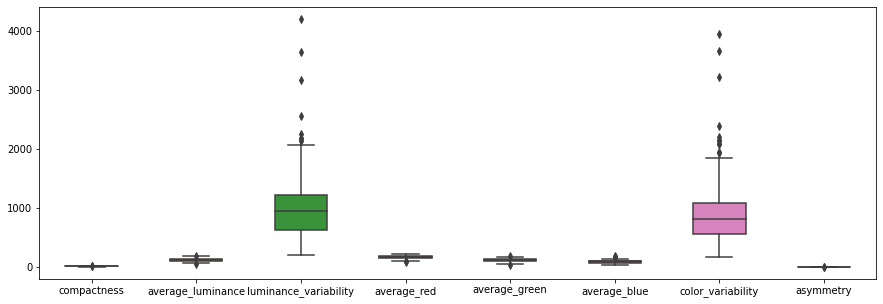

In [ ]:
# distribution of features before normalisation
plt.figure(figsize=(15,5));
sns.boxplot(data=X, width=0.5);

In [ ]:
scaler = StandardScaler().fit(X) # (x - mu) / std 
X = pd.DataFrame(scaler.transform(X), columns=features)

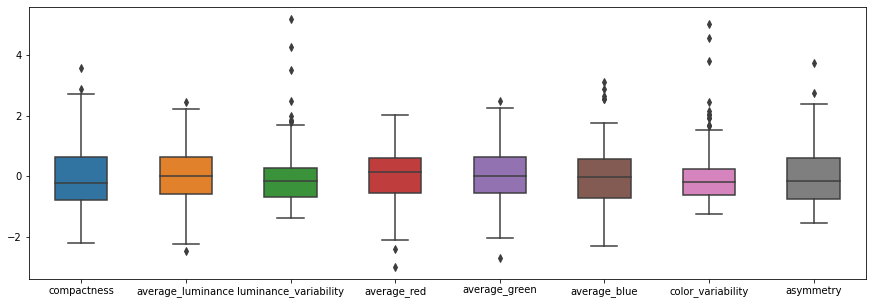

In [ ]:
# distribution of features after normalisation
plt.figure(figsize=(15,5));
sns.boxplot(data=X, width=0.5);

### Train-Test Split
---
Before, we doing anything further with our data, we split our data into a `development` set and a `test` set. The test set will be used to assess the final performance of the model by mimicing a true *out-of-sample* set of datapoints. For this project, we chose a standard split size of `0.3`, meaning that 30% of the original data will be used for testing, and 70% for the development of the model.

We split the data at this early stage to not bias our model towards the test dataset, ie. performing the feature selection process on all of the data, might bias it towards the test data, and thus result in a sligthly overfitted model, that might perform good on the test, but not in real-life. 

*Note: Whenever there is randomness involved, we set `random_state=1` to produce reproducable results.*

In [ ]:
# split into dev-test data (hold-out data to mimic true 'out-of-sample' data)
X_dev, X_test, y_dev, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=1)

In [ ]:
print(X_dev.shape, y_dev.shape)
print(X_test.shape, y_test.shape)

(105, 8) (105, 1)
(45, 8) (45, 1)


### Balancing Data
---
As we have seen in the initial exploration of the data, the labels are heavily imbalanced. Out of the 150 observed images, only 30 are diseased with *melanoma*, which results in precisely 20% of the data. If we would naively train our model disregarding the imbalance and only evaluate the model's performance by its *accuracy score*, we are likely to see a model performing equally or very similar to the so-called *null-hypotheses* (always predicting the dominating label), which would lead to a 80% accuracy in our case. 

To prevent this we balance our data, such that at the end of the process the data we train our model has equal amounts of *melanoma* and *not melanoma*.
There are two ways of doing this:

> **Random Undersampling**: Cutting down the frequency of the dominant label.

> **Random Oversampling**: Duplicating the less dominant feature.

Although, both option are obviously not ideal (since we loose information in the first, and create duplicate information in the second), and we would always prefer a orginally balanced dataset, we need to make a choice. For this project, we *upsampled* our data, since undersampling, would have limited our whole analyis to only 60 images, which is likely to not create an accurate model.

We oversample using `imblearn`'s class `RandomOverSampler`.

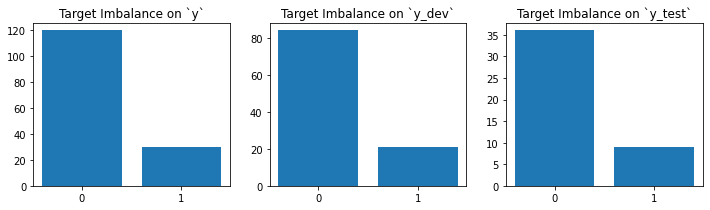

In [ ]:
# plot before oversampling
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
for ax, dataset in zip(axes, [y, y_dev, y_test]):
    unique, counts = np.unique(dataset, return_counts=True)
    ax.bar(unique, counts); ax.set_xticks([1,0])
axes[0].set_title('Target Imbalance on `y`');
axes[1].set_title('Target Imbalance on `y_dev`');
axes[2].set_title('Target Imbalance on `y_test`');

In [ ]:
# balance data (using over-sampling)
oversampler = RandomOverSampler(random_state=1)
X_dev_sampled, y_dev_sampled = oversampler.fit_resample(X_dev, y_dev)

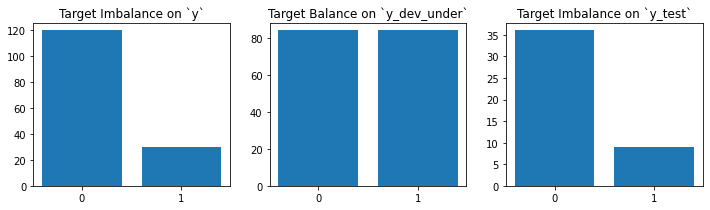

In [ ]:
# plot before oversampling
fig, axes = plt.subplots(ncols=3, figsize=(12, 3))
for ax, dataset in zip(axes, [y, y_dev_sampled, y_test]):
    unique, counts = np.unique(dataset, return_counts=True)
    ax.bar(unique, counts); ax.set_xticks([1,0])
axes[0].set_title('Target Imbalance on `y`');
axes[1].set_title('Target Balance on `y_dev_under`');
axes[2].set_title('Target Imbalance on `y_test`');

In [ ]:
print(f'#Images before Upsampling:   {X_dev.shape[0]}')
print(f'#Images after Upsampling:    {X_dev_sampled.shape[0]}')
print(f'Upsampled Images:            {X_dev_sampled.shape[0]-X_dev.shape[0]}')

#Images before Upsampling:   105
#Images after Upsampling:    168
Upsampled Images:            63


## Feature Selection
---

*Feature Selection* is the process of identifying the most related features from the data and removing the irrelvant or less important features which do not contribute much to our target variable.

There are a number of advantages that come along with feature selection, which make it an important step of every machine learning project.

1. **Reduces Overfitting**: Less redundant data means less opportunity to make decisions based on noise.

2. **Improves Accuracy**: Less misleading data means modeling accuracy improves.

3. **Reduces Training Time**: fewer data points reduce algorithm complexity and algorithms train faster.

(1 choose 8) * (2 choose 8) * (3 choose 8) * ... * (8 choose 8)

### K-Best
---

Statistical tests can be used to select those features that have the strongest relationship with the output variable.
The scikit-learn library provides the `SelectKBest` class that can be used with a suite of different statistical tests to select a specific number of features.

In order to evaluate our features with respect to randomly generated data, we add some uniformly random columns to our development data, in order to select the features that are likely to perform best. 

It is however important to notice, that K-Best Selection is a way of selecting univariate features, meaning that it only checks the likely performance for each single feature. This method might ie. give us 5 individually good performing features, which are highly correlated. In that case, the 4 additionally selected features, don't add any value to our model and thus increase running time and potentially accuracy. 

In [ ]:
FEATURES_SELECTED = {}
FEATURES_SELECTED['kbest'] = {}
FEATURES_SELECTED['sequential'] = {}

---------- k = 1 ----------
luminance_variability
---------- k = 2 ----------
luminance_variability
average_luminance
---------- k = 3 ----------
luminance_variability
average_blue
average_luminance
---------- k = 4 ----------
luminance_variability
average_luminance
compactness
average_blue
---------- k = 5 ----------
luminance_variability
average_luminance
compactness
average_red
average_blue


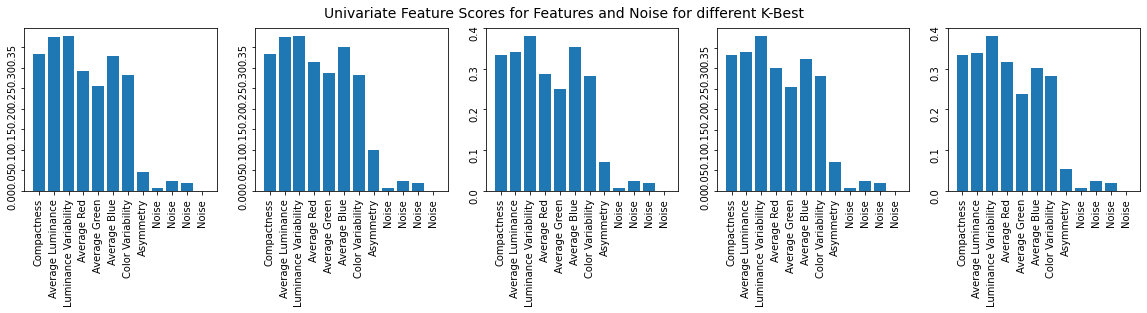

In [ ]:
# generate some noise
noise_cols = 4
noise = np.random.RandomState(1).uniform(0,0.1, size=(noise_cols, X_dev_sampled.shape[0])).transpose()

# feature matrix and target variable
X_select = np.hstack((X_dev_sampled, noise))
y_select = y_dev_sampled

# plot scores for features and noise
fig, ax = plt.subplots(ncols=5, figsize=(4*5, 3))
fig.suptitle('Univariate Feature Scores for Features and Noise for different K-Best', fontsize=14)

# select k-best
for k in range(1,5+1):
    kbest = SelectKBest(mutual_info_classif, k=k)
    kbest.fit(X_select, np.ravel(y_select)) # ravel cause of sklearn warning 
    scores = kbest.scores_ # univariate features scores for each feature and noise

    print('-'*10 + f' k = {k} ' + '-'*10)
    scores_dict = {scores[i]: i for i in range(len(scores))}
    for val in sorted(scores_dict, reverse=True)[:k]:
        print(features[scores_dict[val]])

    ax[k-1].bar(np.arange(0,len(scores)), scores)
    ax[k-1].tick_params(labelrotation=90) # readable labels
    ax[k-1].set_xticks(np.arange(0, len(features) + noise_cols));
    ax[k-1].set_xticklabels([f.replace('_', ' ').title() for f in features] + ['Noise' for _ in range(noise_cols)]);

### Feature Importance using Forward Sequential Feature Selector
---
*description*

In [ ]:
features_noise = features + ['Noise' for _ in range(noise_cols)]

In [ ]:
for k_select in range(1,6):
    forward_selection = SequentialFeatureSelector(KNeighborsClassifier(n_neighbors=3), n_features_to_select=k_select)
    forward_selection.fit(X_select, np.ravel(y_select))
    chosen=forward_selection.get_support()
    print('-'*10 + f' k = {k_select} ' + '-'*10)
    print(np.array(features_noise)[chosen])

---------- k = 1 ----------
['luminance_variability']
---------- k = 2 ----------
['luminance_variability' 'asymmetry']
---------- k = 3 ----------
['luminance_variability' 'asymmetry' 'Noise']
---------- k = 4 ----------
['luminance_variability' 'asymmetry' 'Noise' 'Noise']
---------- k = 5 ----------
['luminance_variability' 'asymmetry' 'Noise' 'Noise' 'Noise']


In [ ]:
############################ trash?
# Feature Importance
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import ExtraTreeClassifier
# load the iris datasets
# fit an Extra Tree model to the data
model = ExtraTreeClassifier()
model.fit(X, y)
model.decision_path(X)
# display the relative importance of each attribute
scores=model.feature_importances_
fig, ax = plt.subplots()
ax.bar(np.arange(0,len(scores)), scores, width=.2,label=r'Feature score')
plt.xticks(rotation = 90) # Rotates X-Axis Ticks by 45-degrees
ax.set_xticks(np.arange(0, len(features) + noise_cols));
ax.set_xticklabels(features + ['Noise' for _ in range(noise_cols)]);
#############################

### Building KNN-Model

For the scope of this project, we first limit ourselves to a basic classifier called `KNN` (*K-Nearest-Neighbors*) algorithm, classifies out-of-sample data by evaluating the label frequency of k-surrounding (mostly measured through *euclidean distance*) neighbors in a n-dimensional space (where n is the number of features).

To build the model, we choose the features selected by *K-Best Features* and and train our model using cross-validation of 10 partitions. In that way we get a more robust estimate for the performance of the metric. 

We will evaluate the final performance on the test-data that was separated in the beginning of this section, to give an estimate of the performance of our model on real-life data.

In [ ]:
selected_features = ['luminance_variability', 'average_luminance']

In [ ]:
X_train, y_train = X_dev_sampled[selected_features], np.ravel(y_dev_sampled) # redfine for simplicity

for k in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='roc_auc') # roc_auc looks at sensitivity and specificity
    print(k,np.mean(scores), np.std(scores))

1 0.8996323529411765 0.04343217478124224
2 0.8943987889273355 0.03717494504144621
3 0.8774005190311419 0.03976372237422438
4 0.8430147058823529 0.05337107355299844
5 0.8190095155709344 0.06023917360738692
6 0.8075908304498268 0.07205730473980654
7 0.7749134948096886 0.08064685592189297
8 0.7539576124567474 0.06473967184848797
9 0.7393166089965397 0.07135516184102382
10 0.7232698961937716 0.07225965136817299


In [ ]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

test_predicted = knn.predict(X_test[selected_features])
confusion = confusion_matrix(y_test, test_predicted)
tp = confusion[1][1] 
tn = confusion[0][0] 
fp = confusion[0][1] 
fn = confusion[1][0] 

#print(test_predicted)
#print(np.array(y_test))

# accuracy
accuracy = (tp + tn) / len(test_predicted) # equivalent to sklearn.metrics.accuracy_score() 

# error 
error = (fp + fn) / len(test_predicted) # 

# sensitivity (also: true-positive-rate or recall)
# how many of the positives did our model detect correctly?
sensitivity = tp / (tp + fn)

# specificity (also: )
# how many of the negatives did our model detect correctly?
specificity = tn / (tn + fp)

print(accuracy)
print(error)
print(sensitivity)
print(specificity)

0.6888888888888889
0.3111111111111111
0.2222222222222222
0.8055555555555556


In [ ]:
def build_knn(features, target=['melanoma'], k=5, scale=True):
    # define predictive and target labels
    X = np.array(DATA['features'][features]) # feature matrix
    y = np.ravel(DATA['features'][target]) # target column

    if scale:
        # normalise features
        scaler = StandardScaler().fit(X) # (x - mu) / std 
        X = scaler.transform(X)

    # balance data (using over-sampling)
    #oversampler = RandomOverSampler(random_state=1)
    #X, y = oversampler.fit_resample(X,y)

    # split into train-test data (hold-out data to mimic true 'out-of-sample' data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

    oversampler = RandomOverSampler(random_state=1)
    X_train, y_train = oversampler.fit_resample(X_train,y_train)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train,y_train, cv=10, scoring='roc_auc')
    print(scores)

    #param_dict = {'n_neighbors': range(1,20)}
    #grid = GridSearchCV(knn, param_dict, cv=10, scoring='roc_auc')
    #grid.fit(X_train, y_train)
    #print(grid.best_estimator_)
    #print(grid.best_params_)
    #print(grid.best_score_)

    # build best_k model and fit entire training data
    #best_k = grid.best_params_['n_neighbors']
    best_knn = KNeighborsClassifier(n_neighbors=k)
    best_knn.fit(X_train, y_train)

    # predict test data
    predicted = best_knn.predict(X_test)
    print(predicted)
    print(y_test)
    confusion = confusion_matrix(y_test, predicted)
    tp = confusion[1][1] 
    tn = confusion[0][0] 
    fp = confusion[0][1] 
    fn = confusion[1][0] 

    # accuracy
    accuracy = (tp + tn) / len(predicted) # equivalent to sklearn.metrics.accuracy_score() 

    # error 
    error = (fp + fn) / len(predicted) # 

    # sensitivity (also: true-positive-rate or recall)
    # how many of the positives did our model detect correctly?
    sensitivity = tp / (tp + fn)

    # specificity (also: )
    # how many of the negatives did our model detect correctly?
    specificity = tn / (tn + fp)

    print(accuracy)
    print(error)
    print(sensitivity) # percentage of correcly detected positives #more important
    print(specificity) # percentage of correctly detected negatives

    #scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    #specificity = cross_val_score(_model, X_train, y_train, cv=10, scoring='')
    #sensitivity = cross_val_score(_model, X_train, y_train, cv=10, scoring='')

In [ ]:
build_knn(features=['luminance_variability', 'average_luminance'], target=['melanoma'], k=1, scale=True)
# okay, our model is robust and good

#knn1.predict([239849]) => 1, 0

# so we can train all our train and give final score on test
#knn.train(x_train, y_train)
#knn.predict(x_test, y_test)

[0.94444444 0.94444444 0.94444444 0.94444444 1.         0.77777778
 0.83333333 0.94444444 0.77777778 0.875     ]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
0.7555555555555555
0.24444444444444444
0.21428571428571427
1.0


*TASK 3*
# Open Question: ...

---
Many things that we could investigate:
- test different classifiers
- try to predict keratosis / or 3-class classification
- play around with sensitivity and specificity
- 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e5a81e04-857d-4bae-844e-8fb924df483a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>